<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/NLP/3_Embeddings/1_Embeddings.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Embedding de palabras (word2vec)

El lenguaje natural es un sistema complejo utilizado para expresar significados.
En este sistema, las palabras son la unidad básica del significado. Como su nombre lo indica, los *vectores de palabras* son vectores que se utilizan para representar palabras y también se pueden considerar como vectores de características o representaciones de palabras. La técnica de mapear palabras a vectores reales se llama **Embedding de palabras**. En los últimos años, los embedding de palabras se han convertido gradualmente en el conocimiento básico del procesamiento del lenguaje natural.





## Los vectores One-Hot son una mala elección

Hasta ahora hemos usado vectores one-hot para representar palabras. Suponga que el número de palabras diferentes en el diccionario (el tamaño del diccionario) es $N$, y cada palabra corresponde a un número entero diferente (índice) de $0$ a $N-1$. Para obtener la representación vectorial one-hot para cualquier palabra con índice $i$, creamos un vector de longitud $N$ con todos 0 y establecemos el elemento en la posición $i$ a 1. De esta manera, cada palabra se representa como un vector de longitud $N$, y puede ser utilizado directamente por redes neuronales.

![Imgur](https://i.imgur.com/brYXUc5.png)



Aunque los vectores one-hot son fáciles de construir, por lo general no son una buena opción. Las principales razones son:
* **Ineficiencia**: El tamaño de cada vector depende del tamaño del vocabulario. Dado que los vocabularios contienen varios cientos de miles de palabras, estos vectores ocupan mucho espacio y están mayormente compuestos de ceros.
* **Ortogonalidad**: Cualquier par de vectores one-hot es ortogonal, por lo tanto no hay una noción natural de similaridad entre ellos.

## Ejemplo inspirador: Embedding de personalidad

En una escala de 0 a 100, ¿qué tan introvertido/extrovertido eres (donde 0 es el más introvertido y 100 es el más extrovertido)? ¿Alguna vez has realizado una prueba de personalidad como la prueba de los Cinco Grandes Rasgos de la Personalidad? Si no lo has hecho, estas son pruebas que te hacen una lista de preguntas, y luego te califican en una serie de ejes, siendo la introversión/extraversión uno de ellos.

Imaginemos que Jay obtuvo una puntuación de 38/100 en el rasgo introversión/extraversión. Podemos graficar eso de esta manera:
![](http://jalammar.github.io/images/word2vec/introversion-extraversion-100.png)

Supongamos que, además de ese, también contemplamos otro de los 5 rasgos y que las escalas de 0 a 100 son reemplazadas por una escala de -1 a 1. Así obtendríamos un vector que represente a Jay de la siguiente manera: 

![](http://jalammar.github.io/images/word2vec/two-traits-vector.png)

Ahora podemos decir que este vector representa parcialmente la personalidad de Jay. La utilidad de tal representación viene cuando compararlo con otras dos personas. Digamos que lo atropella un autobús y necesita ser reemplazado por alguien con una personalidad similar. En la siguiente figura, ¿cuál de las dos personas se parece más a Jay?

![](http://jalammar.github.io/images/word2vec/personality-two-persons.png)

Podemos ver que la persona n° 1 es más parecida a Jay porque gráficamente su vector está más "cerca" al de Jay. Ahora supongamos que tenemos un vector con los 5 rasgos... el análisis gráfico no es una opción. Sin embargo, podemos calcular la similaridad a través del ángulo entre los vectores (que se calcula utilizando el coseno como ya vimos) para obtener una métrica que facilite la comparación.

![](http://jalammar.github.io/images/word2vec/embeddings-cosine-personality.png)

Seguimos viendo que la persona más parecida es la n°1, pero ahora tenemos una métrica para saber cuán mejor reemplazo es con respecto a la otra persona. En los ejercicios asociados a esta clase se puede jugar con un dataset que contiene los vectores asociados a personas reales para ver la utilidad práctica de este concepto.



## Embedding de palabras: ¿Cómo codificamos el significado?

Para que las palabras sean procesadas por modelos de aprendizaje automático, necesitan alguna forma de representación numérica que los modelos puedan usar en sus cálculos. Ahora que entendemos el poder de representación de los vectores, podemos proceder a observar ejemplos de vectores de palabras entrenados (también llamados embeddings de palabras) y comenzar a observar algunas de sus propiedades interesantes.

Word2Vec fue el primer algoritmo en demostrar que podemos usar un vector para representar correctamente las palabras de una manera que capturara las relaciones semánticas o de significado. Por ejemplo, al analizar estos vectores podemos saber si las palabras son similares u opuestas (analizando la dirección y el sentido del vector), o que un par de palabras como “Estocolmo” y “Suecia” tienen entre ellas la misma relación que tienen “El Cairo” y “Egipto” (analizando las distancias entre los vectores), o también relaciones sintácticas o basadas en la gramática (por ejemplo, la relación entre “tenía” y “tengo” es la misma que entre “era” y “es”).

Este es un embedding para la palabra "rey" (vector GloVe entrenado en Wikipedia):

$$[ 0.50451 , 0.68607 , -0.59517 , -0.022801, 0.60046 , -0.13498 , -0.08813 , 0.47377 , -0.61798 , -0.31012 , -0.076666, 1.493 , -0.034189, -0.98173 , 0.68229 , 0.81722 , -0.51874 , -0.31503 , -0.55809 , 0.66421 , 0.1961 , -0.13495 , -0.11476 , -0.30344 , 0.41177 , -2.223 , -1.0756 , -1.0783 , -0.34354 , 0.33505 , 1.9927 , -0.04234 , -0.64319 , 0.71125 , 0.49159 , 0.16754 , 0.34344 , -0.25663 , -0.8523 , 0.1661 , 0.40102 , 1.1685 , -1.0137 , -0.21585 , -0.15155 , 0.78321 , -0.91241 , -1.6106 , -0.64426 , -0.51042 ] $$



Es una lista de 50 números. No podemos decir mucho mirando los valores. Pero visualicémoslo un poco para poder compararlo con otros vectores de palabras. Pongamos todos estos números en una fila y codifiquemos por colores las celdas según sus valores (rojo si están cerca de 2, blanco si están cerca de 0, azul si están cerca de -2):

![](http://jalammar.github.io/images/word2vec/king-colored-embedding.png)

Procederemos ignorando los números y solo observando los colores para indicar los valores de las celdas. Ahora comparemos "Rey" con otras palabras:

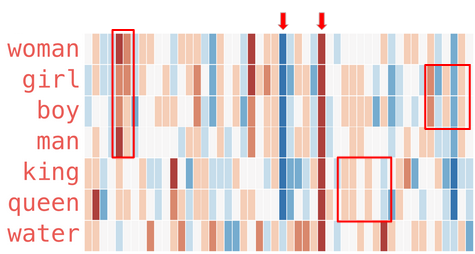

Algunas cosas para señalar:

* Hay una columna roja recta a través de todas estas palabras diferentes. Son similares a lo largo de esa dimensión (y no sabemos qué codifica cada dimensión)
* Puedes ver cómo "mujer" y "niña" son similares entre sí en muchos lugares. Lo mismo con "hombre" y "niño"
* “niño” y “niña” también tienen lugares donde son similares entre sí, pero diferentes de “mujer” u “hombre”. ¿Podrían estar codificando una vaga concepción de la juventud?
* Todas menos la última palabra son palabras que representan personas. Podemos, por ejemplo, ver que la columna azul va hacia abajo y se detiene antes del embedding de "agua".
* Hay lugares claros donde "rey" y "reina" son similares entre sí y distintos de todos los demás. ¿Podrían estar codificando un concepto vago de realeza?



Otro ejemplo más que prueba lo poderosos que son estos embeddings es el concepto de las analogías. Podemos sumar y restar embeddings de palabras y llegar a resultados interesantes. El ejemplo más famoso es la fórmula: "rey" - "hombre" + "mujer":

![](http://jalammar.github.io/images/word2vec/king-analogy-viz.png)

El vector resultante de "rey-hombre+mujer" no es exactamente igual a "reina", pero "reina" es la palabra más cercana de los 400 000 embeddings de palabras que tenemos en esta colección.

Algo importante que debe quedar claro es que, en contraste con los embeddings de personalidad que analizamos anteriormente, ***no sabemos que codifica cada dimensión del vector***. Podemos hacer conjeturas y experimentos que nos permitan validar que estos vectores están modelando de alguna u otra forma la semántica, pero esta codificación de los datos es la que a la red le pareció la más eficiente durante el entrenamiento. 

## Semántica Distribucional

La semántica distribucional es un área de investigación que desarrolla y estudia las teorías y métodos para cuantificar y categorizar las similitudes semánticas entre elementos lingüísticos, según sus propiedades distribucionales en grandes muestras de datos lingüísticos. La idea básica de la semántica distribucional se puede resumir en la llamada hipótesis distribucional: «elementos lingüísticos con distribuciones similares tienen significados similares». 

La hipótesis distribucional se origina de la teoría semántica del uso lingüístico, es decir, palabras que se usan y aparecen en los mismos contextos tienden a transmitir significados parecidos.​ La idea subyacente es *`"dime con quién andas y te diré qué significas"`*.

![Imgur](https://i.imgur.com/bIWcOYp.png)

# Word2Vec: Entrenamiento Auto-supervisado


     


El uso de la semántica distribucional para entrenar modelos de lenguaje tiene una gran ventaja sobre la mayoría de los otros modelos de aprendizaje automático. Esa ventaja es que podemos entrenarlos con texto corriente, que tenemos en abundancia ya que la información que necesitamos es la freecuencia con las que las palabras suelen aparecer juntas.

Piensen en todos los libros, artículos, contenido de Wikipedia y otras formas de datos de texto que tenemos por ahí. Comparen esto con muchos otros modelos de aprendizaje automático que necesitan funciones hechas a mano y datos recopilados especialmente.

![Imgur](https://i.imgur.com/DqdmP5D.png)
    

La herramienta word2vec contiene dos modelos, a saber, ***skip-gram*** y ***continuous bag of words*** **(CBOW)**. Para las representaciones semánticamente significativas, su entrenamiento se basa en probabilidades condicionales que pueden verse como la predicción de las palabras usando algunas de las palabras que las rodean en los corpus. Dado que la supervisión proviene de los datos sin etiquetas, tanto skip-gram como (CBOW) son modelos autosupervisados.

A continuación, presentaremos estos dos modelos y sus métodos de entrenamiento.

### Skipgram



El modelo skip-gram asume que una palabra puede usarse para generar las palabras que la rodean en una secuencia de texto. Considera la probabilidad condicional de generar las palabras de contexto que son aquellas que no están a más de 2 palabras de distancia de la palabra central.

![Imgur](https://i.imgur.com/tTLrqDh.png)





Suponga que las palabras de contexto se generan de forma independiente dada la palabra central (es decir, independencia condicional). En este caso, la probabilidad condicional anterior se puede reescribir como

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$

En el modelo skip-gram, cada palabra tiene dos vectores $d$-dimensionales asociados para calcular probabilidades condicionales. Más concretamente, para cualquier palabra con índice $i$ en el diccionario, denota por $\mathbf{v}_i\in\mathbb{R}^d$ y $\mathbf{u}_i\in\mathbb{R}^ d$ sus dos vectores cuando se usan como una palabra *central* y una palabra *contexto*, respectivamente. La probabilidad condicional de generar cualquier palabra de contexto $w_o$ (con índice $o$ en el diccionario) dada la palabra central $w_c$ (con índice $c$ en el diccionario) se puede modelar mediante una operación softmax sobre el producto punto de los vectores:


$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$

donde se define el conjunto de índices de vocabulario $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$.



Dada una secuencia de texto de longitud $T$, donde la palabra en el paso de tiempo $t$ se denota como $w^{(t)}$. Suponga que las palabras de contexto se generan de forma independiente dada cualquier palabra central.
Para el tamaño de ventana de contexto $m$, la función de probabilidad del modelo skip-gram es la probabilidad de generar todas las palabras de contexto dada cualquier palabra central:


$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t) }),$$

donde se puede omitir cualquier paso de tiempo que sea inferior a $1$ o superior a $T$.

![Imgur](https://i.imgur.com/xgS8JWb.png)

Los parámetros del modelo en skipgram son los vectores que representan tanto a las palabras centrales como a las de contexto. Nuestro objetivo es encontrar estas representaciones vectoriales tratando de maximizar la función de verosimilitud (en inglés likelihood).

$$ L(\theta)=\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t) };\theta)$$

Para transformar esta función en una función de pérdida que se debe minimizar vamos a aplicarle el logaritmo, cambiarle el signo y calcular su valor promedio transformándola en la **verosimilitud logarítmica negativa media**

$$J(\theta) = -\frac{1}{T}\log L(\theta)=-\frac{1}{T}\sum_{t=1}^{T}\sum_{-m \leq j \leq m,\ j \neq 0} \log P(w^{(t+j)} \mid w^{(t) };\theta)$$

![Imgur](https://i.imgur.com/DvRtg5F.png)

Para poder calcular esta función objetivo necesitamos calcular $P(w^{(t+j)} \mid w^{(t) };\theta)$ para lo cual vamos a usar dos vectores por cada palabra $w$:


1.   $v_w$ cuando $w$ es la palabra central 
2.   $u_w$ cuando $w$ es una palabra de contexto 

De esta manera la probabilidad de que aparezca una palabra de contexto (o) dada una palabra central (c) es:

![Imgur](https://i.imgur.com/oaMd0BR.png)



## Continuous Bag of Words (CBOW)


El modelo *continuous bag of words* (CBOW) es similar al modelo skip-gram. La principal diferencia es que CBOW supone que se genera una palabra central en función de las palabras de contexto que la rodean en la secuencia de texto.

![Imgur](https://i.imgur.com/L0hExX0.png)



Dado que hay múltiples palabras de contexto CBOW, estos vectores de palabras de contexto **se promedian** en el cálculo de la probabilidad condicional. Específicamente, para cualquier palabra con el índice $i$ en el diccionario, se denota por $\mathbf{v}_i\in\mathbb{R}^d$ y $\mathbf{u}_i\in\mathbb{R}^d $ a sus dos vectores cuando se usan como una palabra de *contexto* y una palabra *central* respectivamente *(los significados se intercambian en el modelo skip-gram)*.
La probabilidad condicional de generar cualquier palabra central $w_c$ (con índice $c$ en el diccionario) dadas las palabras de contexto que la rodean $w_{o_1}, \ldots, w_{o_{2m}}$ (con índice $o_1, \ldots, o_{2m}$ en el diccionario) puede ser modelado por



$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}\left(\frac{1}{2m}\mathbf{u}_c^ \top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \text{exp }\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right )}.$$

Para abreviar, sea $\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$ el conjunto de las palabras de contexto en la ventana actual y $\bar{\mathbf{v}}_o = \left(\mathbf {v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}} \right)/(2m)$ el vector promedio obtenido a partir de esas palabras. Entonces la ecuación anterior se puede simplificar como

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{ i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

 Dada una secuencia de texto de longitud $T$, donde la palabra en el paso de tiempo $t$ se denota como $w^{(t)}$.
Para el tamaño de la ventana de contexto $m$,
la función de verosimilitud de CBOW
es la probabilidad de generar todas las palabras centrales
dadas sus palabras de contexto:


$$ \prod_{t=1}^{T} P(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t +1)}, \ldots, w^{(t+m)}).$$

## Comparación de Ambos Modelos

![Imgur](https://i.imgur.com/iSiYodt.png)

## Muestreo Negativo


Debido a que la operación softmax ha considerado que la palabra de contexto podría ser **cualquier palabra** en el diccionario V, la función de pérdida mencionada anteriormente incluye en realidad **una suma tan grande como el mismo diccionario**. Para diccionarios más grandes con cientos de miles o incluso millones de palabras, la sobrecarga para calcular cada gradiente puede ser demasiado alta. 

![Imgur](https://i.imgur.com/37bpOrt.png)

Para reducir tal complejidad computacional, presentaremos un método de entrenamiento aproximados a continuación: muestreo negativo. 

El muestreo negativo consiste en transformar el problema de clasificación que plantea skipgram (cuál es la palabra de contexto dada la central) en un **problema de regresión** que me devuelva la probabilidad de que dos palabras sean vecinas.

![Imgur](https://i.imgur.com/PyZNQss.png)

Este simple cambio transforma nuestra regresión softmax (usada para clasificación multiclase) en una regresión logística (usada para clasificación binaria) por lo que se vuelve mucho más simple y mucho más rápido de calcular.

Este cambio requiere que cambiemos la estructura de nuestro conjunto de datos: la etiqueta ahora es una nueva columna con valores 0 o 1. Todos serán 1 ya que todas las palabras que agregamos son vecinas.

![Imgur](https://i.imgur.com/vHK8Xdg.png)

Esto ahora se puede calcular a una velocidad vertiginosa, procesando millones de ejemplos en minutos. Pero hay un cabo suelto. Si todos nuestros ejemplos son positivos (etiqueta: 1), nos abrimos a la posibilidad de un modelo sabelotodo que **siempre devuelve 1**, logrando un 100% de accuracy, pero sin aprender nada y generando embeddings basura.

Para impedir esto, debemos introducir **`muestras negativas`** en nuestro conjunto de datos: muestras de palabras que no son vecinas. Nuestro modelo necesita devolver 0 para esas muestras. Ahora, ese es un desafío que el modelo tiene que trabajar duro para resolver, pero aún a una velocidad increíblemente rápida.

![Imgur](https://i.imgur.com/PYOFSMc.png)

Llamemos $S$ al evento de que una palabra de contexto $w_o$ provenga de la ventana de contexto de una palabra central $w_c$. Para que este evento involucre palabras $w_o$, que provengan de una distribución predefinida $P(w)$, muestreemos $K$ *palabras negativas* que no son de esta ventana de contexto. Llamemos $N_k$ al evento de que una palabra negativa $w_k$ ($k=1, \ldots, K$)
no provenga de la ventana de contexto de $w_c$. Suponga que estos eventos que involucran tanto el ejemplo positivo como los ejemplos negativos $S, N_1, \ldots, N_K$ son mutuamente independientes. El muestreo negativo reescribe la probabilidad conjunta (involucrando solo ejemplos positivos) como

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t) }),$$

donde la probabilidad condicional se aproxima a través de los eventos $S, N_1, \ldots, N_K$:

$$ P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).$$

Si llamamos por $i_t$ y $h_k$ los índices de una palabra $w^{(t)}$ en el paso de tiempo $t$ de una secuencia de texto y una palabra negativa $w_k$, respectivamente. La pérdida logarítmica con respecto a las probabilidades condicionales es

$$
\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&- \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&- \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}
$$


Podemos ver que ahora el costo computacional de los gradientes en cada paso de entrenamiento no tiene nada que ver con el tamaño del diccionario, sino que depende linealmente de $K$. Al establecer el hiperparámetro $K$ en un valor menor, el costo computacional de los gradientes en cada paso de entrenamiento con muestreo negativo es menor.

## Entrenamiento

Al comienzo de la fase de entrenamiento, creamos dos matrices: una matriz de embedding y una matriz de contexto. Estas dos matrices tienen un embedding de palabra central y de contexto respectivamente para cada palabra en nuestro vocabulario. 

![Imgur](https://i.imgur.com/YY2jU6Q.png)


Estas dos matrices funcionan como capas que transfroman los índices de token en vectores. Para cada ejmplo de entrenamiento hacemos pasar los índices de las palbras centrales y de contexto por sus respectivas capas y obtenemos sus embeddings.

![Imgur](https://i.imgur.com/qjIjDZN.png)

Luego se calcula el producto punto entre el vector de la palabra central por cada uno de los vectores de contexto y negativos para obtener una medida de qué tan similares son (dado que el producto punto es proporcional al coseno).

![Imgur](https://i.imgur.com/vWco0hG.png)

Por último, se calcula la función de pérdida (que habíamos definido como la sigmoidea y eso se utiliza para modificar los parámetros. 

![Imgur](https://i.imgur.com/PpgE131.png)

La particularidad del entrenamiento de embeddings es que los embeddings que queremos obtener como salida son los mismos parámetros que estamos entrenando. En el caso de word2vec, los embeddings finales se obtendrán de la matriz de palabras centrales, mientras que la matriz de contexto es descartada.



# GloVe: Embeddings de palabras con Vectores Globales

Las co-ocurrencias palabra-palabra dentro de las ventanas de contexto pueden llevar información semántica rica. Por ejemplo, en un corpus grande, es más probable que la palabra "sólido" coincida con "hielo" que con "vapor", pero la palabra "gas" probablemente coincida con "vapor" con más frecuencia que con "hielo". 

Además, las estadísticas del corpus global de tales co-ocurrencias pueden precalcularse: esto puede conducir a un entrenamiento más eficiente. Para aprovechar la información estadística en todo el corpus para los embeddings de palabras, primero revisemos el modelo skip-gram, pero interpretándolo usando estadísticas globales del corpus, como recuentos de co-ocurrencia.

## Razón de la Probabilidades de Co-ocurrencia

Sea $p_{ij} \stackrel{\mathrm{def}}{=} P(w_j \mid w_i)$ la probabilidad condicional de generar la palabra de contexto $w_j$ dada $w_i$ como palabra central en el corpus. La siguiente tabla enumera varias probabilidades de co-ocurrencia dadas las palabras "hielo" y "vapor" y sus proporciones basadas en estadísticas de un gran corpus.

|$w_k$=|sólido|gas|agua|moda|
|:--|:-|:-|:-|:-|
|$p_1=P(w_k\mid\text{hielo})$|0.00019|0.000066|0.003|0.000017|
|$p_2=P(w_k\mid\text{vapor})$|0.000022|0.00078|0.0022|0.000018|
|$p_1/p_2$|8.9|0.085|1.36|0.96|



Podemos observar lo siguiente:

* Para una palabra $w_k$ que está relacionada con "hielo" pero no con "vapor", como $w_k=\text{solid}$, esperamos una mayor proporción de probabilidades de co-ocurrencia, como 8.9.
* Para una palabra $w_k$ que está relacionada con "vapor" pero no con "hielo", como $w_k=\text{gas}$, esperamos una proporción más pequeña de probabilidades de co-ocurrencia, como 0.085.
* Para una palabra $w_k$ que está relacionada tanto con "hielo" como con "vapor", como $w_k=\text{agua}$, esperamos una relación de probabilidades de co-ocurrencia cercana a 1, como 1.36 .
* Para una palabra $w_k$ que no está relacionada tanto con "hielo" como con "vapor", como $w_k=\text{moda}$, esperamos una relación de probabilidades de co-ocurrencia cercana a 1, como 0.96 .





## Función de Pérdida
Se puede ver que la relación de probabilidades de co-ocurrencia puede expresar intuitivamente la relación entre palabras.
Por lo tanto, podemos diseñar una función de tres vectores de palabras para ajustar esta razón.
Para la razón de probabilidades de co-ocurrencia
${p_{ij}}/{p_{ik}}$ con $w_i$ siendo la palabra central y $w_j$ y $w_k$ siendo las palabras de contexto, queremos ajustar esta proporción usando alguna función $f$:



$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.$$

En el paper de GloVe se decide usar f como una exponencial:

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.$$

Ahora elijamos $\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$,
donde $\alpha$ es una constante. Como $p_{ij}=x_{ij}/x_i$, después de sacar el logaritmo en ambos lados obtenemos $\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i$. Podemos usar términos de sesgo adicionales para ajustar $- \log\, \alpha + \log\, x_i$, como la palabra central bias $b_i$ y la palabra de contexto bias $c_j$:

$$\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log\, x_{ij}.$$

El siguiente gráfico explica un mejor mejor el desarrollo matemático de la fórmula.
![Imgur](https://i.imgur.com/vjlm4kS.png)


Al hacer mínimos cuadrados sobre la ecuación de arriba nos queda una función de pérdida como la siguiente:

$$\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.$$

Donde $h(x_{ij})$ es un hiperparámetro que indica qué tanto poder debe tener la coocurrencia calculada en el resulltado de la función de pérdida.

## Aclaraciones sobre GloVe



Algunas particulares del entrenamiento de GloVe hace que haya sutiles diferencias con word2vec. A saber:
1. Aunque usemos SGD con minilotes, los xij se calculan de antemano basados en el **dataset completo**. Por eso se llaman `vectores globales (Global Vectors)`.
2. Observe que si la palabra $w_i$ aparece en la ventana de contexto de la palabra $w_j$, entonces la palabra $w_j$ también aparecerá en la ventana de contexto de la palabra $w_i$. Por lo tanto, $x_{ij} = x_{ji}$. Esto quiere decir que el embedding de palabra central y el embedding de palabra de contexto de cualquier palabra deberían ser **equivalentes** en GloVe. Sin embargo, los dos embeddings que son aprendidos para la misma palabra pueden ser diferentes al final debido a diferentes valores de inicialización. Después de aprender todos los embeddings, GloVe utilizará `la suma del vector de la palabra central y el vector de la palabra de contexto` como el embedding final de la palabra.

# fastText: Añadiendo morfología



La morfología es la rama de la lingüística que estudia la estructura interna de las palabras para definir y clasificar sus unidades: las variantes de las palabras y la formación de nuevas palabras.

Ni word2vec ni GloVe utilizan la morfología para generar sus embeddings. Por ejemplo, "perro" y "perros" están representados por dos vectores diferentes, mientras que la relación entre estos dos vectores no se representa directamente en el modelo.

fastText [Bojanowski et al., 2017] propone el método de embedding de subpalabras, intentando así introducir información morfológica en el modelo skip-gram en word2vec.
En fastText, cada palabra central se representa como una colección de ngramas. 

![Imgur](https://i.imgur.com/0eUvdHm.png)

En fastText, para una palabra $w$, registramos la unión de todas sus subpalabras con longitud de 3 a 6 y subpalabras especiales como $G_w$. Así, el diccionario es la unión del conjunto de subpalabras de todas las palabras.

$$\mathbf{v}_w=\sum_{g\in\mathcal{G_w}} \mathbf{z}_g$$

El resto de fastText es lo mismo que el modelo skip-gram. En comparación con el modelo skip-gram, el vocabulario en fastText es más grande, lo que da como resultado más parámetros del modelo. Además, para calcular la representación de una palabra, todos sus vectores de subpalabras deben sumarse, lo que genera una mayor complejidad computacional. Sin embargo, gracias a los parámetros compartidos de subpalabras entre palabras con estructuras similares, las palabras raras e incluso las palabras fuera del vocabulario pueden obtener mejores representaciones vectoriales en fastText.

## Codificación por Pares de Bytes

fastText fue la primera propuesta en utilizar subpalabras en los embeddings y permitió obtener mejores vectores para palabras complejas menos comunes, incluso palabras que no existen en el diccionario, mirando otras palabras con estructuras similares.
Sin embargo, su diseño tan inocente tiene algunas desventajas:
* **el diccionario es más grande**, lo que resulta en más parámetros y modelos más complejos,
* el vector de una palabra requiere la **suma de todos los vectores de subpalabras**, lo que da como resultado una mayor complejidad de cálculo
* los n-gramas tienen una longitud fija que debe definirse de antemano
* el método FastText asume implícitamente que cada n-grama es igualmente importante independientemente del contexto, pero, en realidad, ese no es el caso porque **no todos los n-gramas son un morfema**.

Para permitir subpalabras de longitud variable en un vocabulario de tamaño fijo, podemos aplicar un algoritmo de compresión llamado `codificación de pares de bytes (BPE)` para extraer subpalabras.

La codificación de pares de bytes realiza un análisis estadístico del conjunto de datos de entrenamiento para descubrir símbolos comunes dentro de una palabra, como caracteres consecutivos de longitud arbitraria. A partir de símbolos de longitud 1, la codificación de pares de bytes fusiona iterativamente el par más frecuente de símbolos consecutivos para producir nuevos símbolos más largos. Tenga en cuenta que, por motivos de eficacia, no se tienen en cuenta los pares que cruzan los límites de las palabras. Al final, podemos usar tales símbolos como subpalabras para segmentar palabras. La codificación de pares de bytes y sus variantes se han utilizado para representaciones de entrada en modelos populares de preentrenamiento de procesamiento de lenguaje natural como GPT-2 (Radford et al., 2019) y RoBERTa (Liu et al., 2019). A continuación, ilustraremos cómo funciona la codificación de pares de bytes.

Supongamos que nuestro dataset se compone de las siguientes tres frases, extraeremos sus ngramas de longitud 1 y calcularemos su frecuencia.

![Imgur](https://i.imgur.com/91u0aGS.png)


Luego se detecta el ngrama de longitud 2 más frecuente y se fusionan los dos ngramas de longitud 1 que lo componen (es decir la cantidad de veces que las letras aparecen juntas se le resta a la cantidad de veces total que aparecen)

![Imgur](https://i.imgur.com/1MN8OU9.png)

Luego seguimos con los siguientes ngramas de longitud 2 más frecuentes, y luego fusionamos estos para formar ngramas de longitud 3 y así sucesivamente.

![Imgur](https://i.imgur.com/hv2Uuy5.png)

Si piensa un rato seguramente llegará al problema con este método. Es que si no establecemos un sistema de frenado, el algoritmo seguirá hasta que cada ngrama sea una palabra completa.

![Imgur](https://i.imgur.com/sSDqa19.png)

Generalmente se utiliza una cantidad de iteraciones del algoritmo para evitar este problema. Esta cantidad es un hiperparámetro que depende del tamaño del vocabulario.